<a href="https://colab.research.google.com/github/onejbsmith/ExportedData/blob/main/Identifying_Candlestick_Patterns_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  <details>
    <summary>
<h1>Identifying Candlestick Patterns using Deep Learning</h1>
    </summary>

#### Training a neural network on candlestick charts and then using it to identify patterns on it

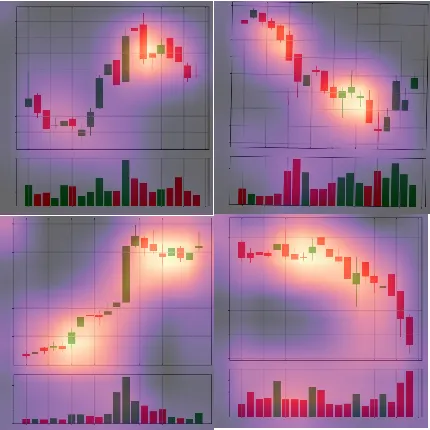

*Some of the heatmaps generated using the method described below (Image by author).*

Recently I completed a very interesting project wherein I attempted to identify candlestick patterns on charts of Large Cap Indian stocks using Deep learning, and the results were very interesting! This blog is a tutorial so that you can try out this fascinating “Experiment” on your own.

> **I am calling this an “Experiment” to emphasize that it is one and to make it very clear that you should not take any financial decisions based on the content given here!**

Briefly, we will be executing the following steps (using python) :

- Collecting the daily historical stock data for multiple stocks using the python library nsepy.
- Converting the data into Candlestick charts.
- Labelling the Candlestick charts as having an “Up” or “Down” movement based on percentage movement (of close price) in a particular direction.
- Training a Deep Learning Model on the data.
- Getting the areas of interest (based on the values of activations)and visualizing them using heat maps.

You can find the GitHub repo containing the Jupyter Notebooks for this project [here](https://github.com/shaan2909/Deep-Learning-for-Candle-Stick-Patterns-Identification). We will be requiring the following libraries as we move ahead :

- nsepy
- pandas
- numpy
- matplotlib
- fastai

I will be explaining the code piece by piece. So let’s get started!
  </details>

In [ ]:
#@title #Imports
!pip install nsepy
from datetime import date
from nsepy import get_history
import pandas as pd
import traceback

In [ ]:
#@title #Get Candle data from github Tick data
import pandas as pd
from datetime import datetime, timedelta
from pandas import DataFrame
#Coverts tick data to data frame with date Time column
def obtain_data2(setNumber=2):

  url = f"https://raw.githubusercontent.com/onejbsmith/ExportedData/main/MNQ%2006-23-032723-tick.Last.{setNumber}.csv"
  df = pd.read_csv(url,parse_dates={'DateTime':['Day',' Time']})

  #print(df)

  #Give the dataframe a datetime index

  df = df.assign(Timestamp = pd.to_datetime(df['DateTime'],unit='s')).set_index('DateTime')
  df = df.dropna()
  # Convert tick rows to candles

  candle_duration = '1T';
  candle_column = ' Last'
  volume_column = ' Size'
  #candle_column = ' Bid'
  #df = df.resample(candle_duration)[candle_column].ohlc()
  df = df.resample(candle_duration).agg({candle_column : 'ohlc',volume_column : 'sum'})
  df.dropna()
  df=df.reset_index()
  df=df.rename({'DateTime':'Date','open':'open_price','close':'close_price',' Size':'volume'},axis='columns')
  df.index.names = ['Date']
  #df.index=df.DateTime
  
  return df
  #print(df)

  #df.info()
  #print(df)
  #df.index
  # x1 = df.high;
  # x2 = df.low;

  # x1 = x1.dropna()
  # x2 = x2.dropna()

  # x1
  # x2

df_pricing = obtain_data2(2)
# print(df_pricing)

In the above piece of code we have defined functions to obtain the historical stock data and to plot Candlestick charts for it. A brief overview :

- The function “obtain\_data” takes the ticker symbol and the start and end dates as input and gives out a Pandas Dataframe containing the stock data.
- The function “plot\_candles” (which was originally written by Daniel Treiman to which I have made minor changes) takes in the Pandas Dataframe and outputs a Candlestick chart.

In [ ]:
#@title Create Folders for Candle Data
import os
if not os.path.isdir("Candle Data"):  
  os.mkdir("Candle Data")
  os.mkdir("Candle Data/Up")
  os.mkdir("Candle Data/Down")
  os.mkdir("Candle Data/None")

In [ ]:
#@title #def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb;

"""This cell defineds the plot_candles function"""
def default_color(index, open_price, close_price, low, high):
    return 'r' if open_price[index] > close_price[index] else 'g'

def candle_color(pricing):
  open_price = pricing.get((' Last','open_price'))
  close_price = pricing.get((' Last','close_price'))
  low = pricing.get((' Last','low'))
  high = pricing.get((' Last','high'))        
  x = np.arange(len(pricing))
  candle_colors = [default_color(i, open_price, close_price, low, high) for i in x]
  return candle_colors

    

def plot_candles(pricing, title=None, volume_bars=False, color_function=default_color, technicals=None,candle_colors=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """

    try:
      #color_function = color_function or default_color
      technicals = technicals or []
      open_price = pricing.get((' Last','open_price'))
      close_price = pricing.get((' Last','close_price'))
      low = pricing.get((' Last','low'))
      high = pricing.get((' Last','high'))
      oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
      oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
      
      
      if volume_bars:
          fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]},figsize=(7,7), facecolor='black')
      else:
          fig, ax1 = plt.subplots(1, 1, facecolor='black')
      if title:
          ax1.set_title(title, color= 'white')
      ax1.set_facecolor("black")

      fig.tight_layout()
      # x = np.arange(len(pricing))
      # candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
      #print("Colors=",candle_colors)
      x = np.arange(len(pricing))
      candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
      lines = ax1.vlines(x , low, high, color=candle_colors, linewidth=1)
      ax1.xaxis.grid(True)
      ax1.yaxis.grid(True)
      ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
      ax1.set_yticklabels([])
      #ax1.set_xticklabels([x.min(), x.max()])
      # Assume minute frequency if first two bars are in the same day.
      frequency = 'minute' #if (pricing.index[1] - pricing.index[0]) == 0 else 'day'
      time_format = '%d-%m-%Y'
      if frequency == 'minute':
          time_format = '%H:%M'
      # Set X axis tick labels.
      #plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
      for indicator in technicals:
          ax1.plot(x, indicator)
      
      if volume_bars:
          volume = pricing[('volume','volume')]
          volume_scale = None
          scaled_volume = volume
          if volume.max() > 1000000:
              volume_scale = 'M'
              scaled_volume = volume / 1000000
          elif volume.max() > 1000:
              volume_scale = 'K'
              scaled_volume = volume / 1000
          ax2.bar(x, scaled_volume, color=candle_colors)
          volume_title = 'Volume'
          if volume_scale:
              volume_title = 'Volume (%s)' % volume_scale
          #ax2.set_title(volume_title)
          ax2.xaxis.grid(True)
          ax2.set_yticklabels([])
          ax2.set_xticklabels([])
          ax2.set_facecolor("black")    
    except:
      traceback.print_exc()          
      breakpoint()       
      pass

    finally:    
      return fig, (ax1, ax2)   

In [ ]:
#@title #def redraw_candles(fig, pricing, title=None, volume_bars=False, color_function=None, technicals=None):

def redraw_candles(ax1, ax2, pricing, title=None, volume_bars=False, color_function=default_color, technicals=None,candle_colors=None):
    """ redraws a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """

    try:
      #color_function = color_function or default_color
      technicals = technicals or []
      open_price = pricing.get((' Last','open_price'))
      close_price = pricing.get((' Last','close_price'))
      low = pricing.get((' Last','low'))
      high = pricing.get((' Last','high'))
      oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
      oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
      
      
      # if volume_bars:
      #     fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]},figsize=(7,7), facecolor='black')
      # else:
      #     fig, ax1 = plt.subplots(1, 1, facecolor='black')
      # if title:
      #     ax1.set_title(title, color= 'white')
      # #ax1.set_facecolor("black")

      # fig.tight_layout()
      # x = np.arange(len(pricing))
      # candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
      #print("Colors=",candle_colors)
      x = np.arange(len(pricing))
      candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
      lines = ax1.vlines(x , low, high, color=candle_colors, linewidth=1)
      ax1.xaxis.grid(True)
      ax1.yaxis.grid(True)
      ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
      ax1.set_yticklabels([])
      #ax1.set_xticklabels([x.min(), x.max()])
      # Assume minute frequency if first two bars are in the same day.
      frequency = 'minute' #if (pricing.index[1] - pricing.index[0]) == 0 else 'day'
      time_format = '%d-%m-%Y'
      if frequency == 'minute':
          time_format = '%H:%M'
      # Set X axis tick labels.
      #plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
      for indicator in technicals:
          ax1.plot(x, indicator)
      
      if volume_bars:
          volume = pricing[('volume','volume')]
          volume_scale = None
          scaled_volume = volume
          if volume.max() > 1000000:
              volume_scale = 'M'
              scaled_volume = volume / 1000000
          elif volume.max() > 1000:
              volume_scale = 'K'
              scaled_volume = volume / 1000
          ax2.bar(x, scaled_volume, color=candle_colors,facecolor='black')
          volume_title = 'Volume'
          if volume_scale:
              volume_title = 'Volume (%s)' % volume_scale
          #ax2.set_title(volume_title)
          ax2.xaxis.grid(True)
          ax2.set_yticklabels([])
          ax2.set_xticklabels([])
          #ax2.set_facecolor("black")    
    except:
      traceback.print_exc()          
      breakpoint()       
      pass

    #finally:    
      #return fig, (a1, a2)    

In [ ]:
#@title #Create Candlestick charts
equities=['BAJFINANCE','RELIANCE','INFY','HDFC','HDFCBANK','HDFCLIFE','ZEEL','DELTACORP','ITC','ASIANPAINT']
equities = [1,2]

for equity in equities :
    # df_pricing=obtain_data(equity,date(2018,1,1),date(2020,9,1))
    df_pricing=obtain_data2(equity)
    df=df_pricing.copy()
    df=df.reset_index(drop=True)
    n_days=5
    fraction_movement=0.0000037
    df[(' Last',  'Trend')]=None
    colors = candle_color(df)
    for i in range(len(df)):
        try :
            for n in range(n_days): 
                fwd_diff = df.loc[i,(' Last',  'close_price')] - df.loc[i+n,(' Last',  'close_price')]
                tolerance = fraction_movement*df.loc[i,(' Last',  'close_price')]
                bwd_diff = df.loc[i+n,(' Last',  'close_price')] - df.loc[i,(' Last',  'close_price')]
                print(fwd_diff, bwd_diff, tolerance)
                pricing = df_pricing[i-20:i]
                label = df.loc[i,('Date','')]
                #print(i, fwd_diff>=tolerance, bwd_diff>=tolerance)
                #breakpoint()
                if  fwd_diff >= tolerance:
                    df.loc[i,(' Last',  'ate')] ='Down'
                    if i >=20 :
                        fig=plot_candles(pricing, title=f"{i} Down {label}", volume_bars=True, candle_colors=colors)
                        fig.savefig('Candle Data/Down/{0}{1}.png'.format('MNQ',label),dpi=70)
                        print('Down',i,n)
                    break
                elif bwd_diff >= tolerance :
                    df.loc[i,(' Last',  'Trend')]='Up'
                    if i >20 :    
                        fig=plot_candles(pricing,title=f"{i} Up {label}",volume_bars=True, candle_colors=colors)
                        fig.savefig('Candle Data/Up/{0} {1}.png'.format('MNQ',label),dpi=70)
                        print('Up',i,n)
                    break
                else :
                    df.loc[i,(' Last',  'Trend')]= 'No Trend'
                    #print('None',i,n,fwd_diff,bwd_diff, tolerance)
        except:
            print(f"Row #: {i}")
            traceback.print_exc()          
            breakpoint()       
            pass


0.0 0.0 0.047916850000000004
-1.25 1.25 0.047916850000000004
0.0 0.0 0.047921475000000005
1.25 -1.25 0.047921475000000005
0.0 0.0 0.047916850000000004
0.0 0.0 0.047916850000000004
1.5 -1.5 0.047916850000000004
0.0 0.0 0.047916850000000004
1.5 -1.5 0.047916850000000004
0.0 0.0 0.047911300000000004
0.25 -0.25 0.047911300000000004
0.0 0.0 0.047910375000000005
1.0 -1.0 0.047910375000000005
0.0 0.0 0.047906675
0.25 -0.25 0.047906675
0.0 0.0 0.047905750000000004
0.0 0.0 0.047905750000000004
0.75 -0.75 0.047905750000000004
0.0 0.0 0.047905750000000004
0.75 -0.75 0.047905750000000004
0.0 0.0 0.047902975
1.25 -1.25 0.047902975
0.0 0.0 0.04789835
-0.75 0.75 0.04789835
0.0 0.0 0.047901125
-1.0 1.0 0.047901125
0.0 0.0 0.047904825000000005
-1.25 1.25 0.047904825000000005
0.0 0.0 0.04790945
1.25 -1.25 0.04790945
0.0 0.0 0.047904825000000005
1.5 -1.5 0.047904825000000005
0.0 0.0 0.047899275000000005
-1.0 1.0 0.047899275000000005
0.0 0.0 0.047902975
1.25 -1.25 0.047902975
0.0 0.0 0.04789835
1.0 -1.0 0

Traceback (most recent call last):
  File "<ipython-input-6-3149e556817d>", line 29, in <cell line: 5>
    fig.savefig('Candle Data/Down/{0}{1}.png'.format('MNQ',label),dpi=70)
AttributeError: 'tuple' object has no attribute 'savefig'

PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.9/bdb.py", line 334, in set_trace
    sys.settrace(self.trace_dispatch)



Row #: 20
> <ipython-input-6-3149e556817d>(45)<cell line: 5>()
     42         except:
     43             print(f"Row #: {i}")
     44             traceback.print_exc()
---> 45             breakpoint()
     46             pass




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.9/bdb.py", line 359, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
0.0 0.0 0.0478817
-3.0 3.0 0.0478817


Traceback (most recent call last):
  File "<ipython-input-6-3149e556817d>", line 45, in <cell line: 5>
    breakpoint()
AttributeError: 'tuple' object has no attribute 'savefig'


Row #: 21
> <ipython-input-6-3149e556817d>(45)<cell line: 5>()
     42         except:
     43             print(f"Row #: {i}")
     44             traceback.print_exc()
---> 45             breakpoint()
     46             pass



In [ ]:
#@title #def obtain_data
def obtain_data(ticker,start,end):
# Enter the start and end dates using the method date(yyyy,m,dd)    
    stock=get_history(symbol=ticker,start=start,end=end)
    df=stock.copy()
    df=df.reset_index()
    df=df.drop(['Series','Prev Close','Last','Turnover','%Deliverble','Trades'],axis=1)
    df=df.rename({'Open':'open_price','Close':'close_price','High':'high','Low':'low','Volume':'volume'},axis='columns')
    df.index=df.Date
    return df